# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit  # fit the data with a given form
from scipy import integrate

# import the packages for symbolic regression
import sympy
import pydotplus
from IPython.display import Image
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sympy.plotting import plot as symplot
from IPython.display import Image, display, Latex

import os
import sys
sys.path.append("../")
from utils import createDataDic  # Self-mdae function stored in python file

In [2]:
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)

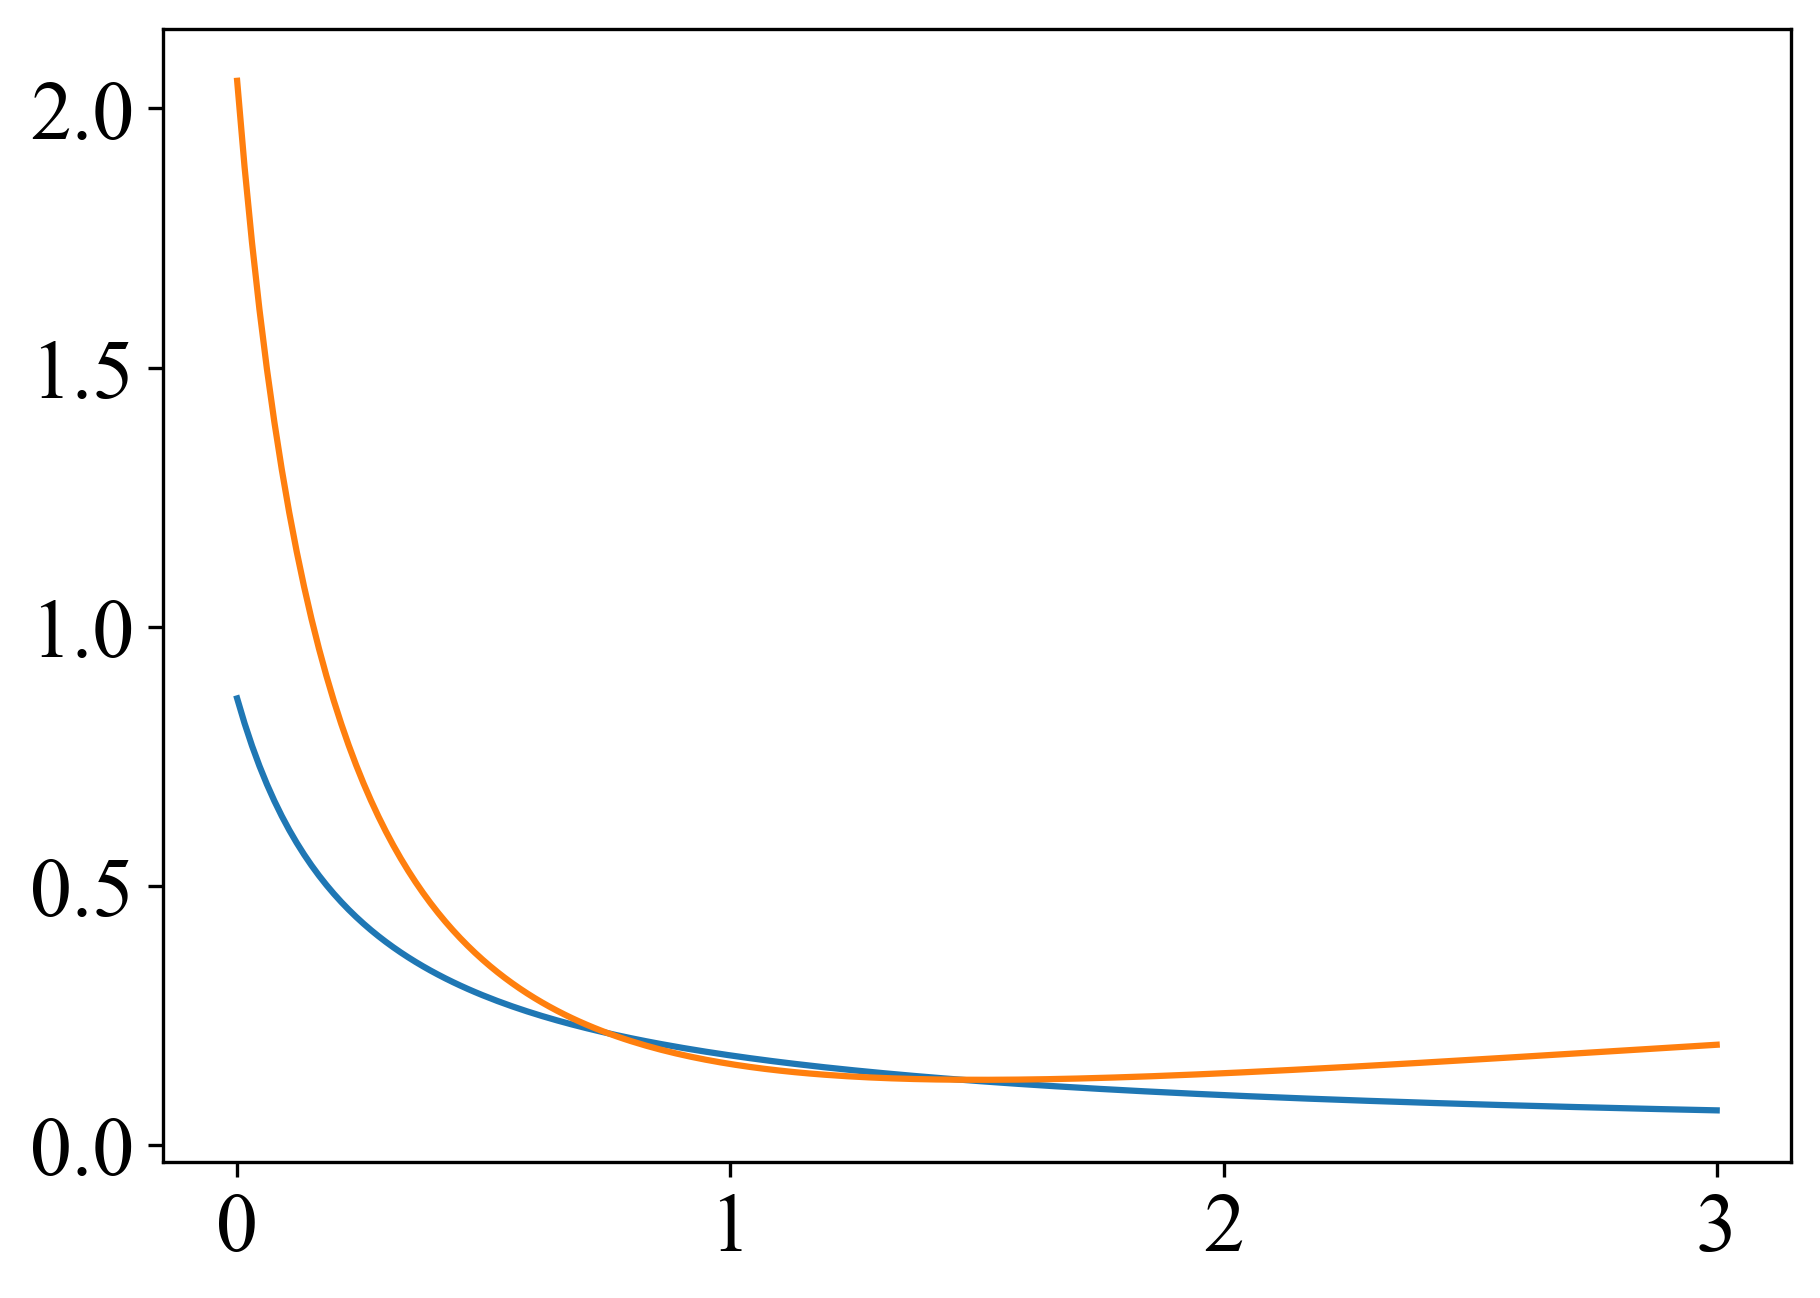

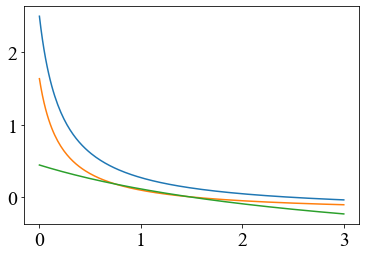

In [10]:
def babbageWith(x):
    return (1.515-x) / (3.39+1.04*x)

def babbageNo(x):
    return (4.62-3*x) / (13.4368*x + 2.82)

def theory(x):
    return (2.5-x)/ (1+4.5*x)

x = np.linspace(0, 3, 200)
fig = plt.figure(figsize=(7, 5), dpi=300)
plt.plot(x, theory(x) - babbageNo(x), label="No penalty")
plt.plot(x, theory(x) - babbageWith(x), label="With penalty")
plt.show()

fig = plt.figure()
plt.plot(x, theory(x))
plt.plot(x, babbageNo(x))
plt.plot(x, babbageWith(x))


# Data Preprocessing

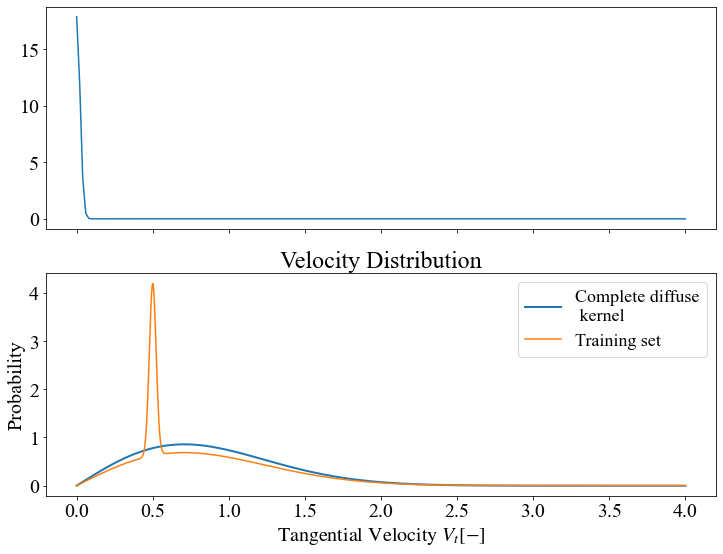

In [3]:
class CreateData():
    def __init__(self, alpha=0.9, vi=-0.5, traing_range=[-4, 4]):
        self.alpha = alpha
        self.VI = vi
        self.x_lower = traing_range[0]
        self.x_upper = traing_range[1]
    
    def diracFunc(self, x):
        """Dirac Delta Function."""
        return 17.85*np.exp(-x**2/0.001)
#         return 5.641896*np.exp(-x**2/0.01)
    
    def theoDataNormal(self, x):
        """Tangential velocity part of complete diffuse kernel."""
        f1 = 2* x* np.exp(-np.power(x, 2))
        f2 = self.diracFunc(self.VI + x)

        return f1, self.alpha*f1 + (1-self.alpha)*f2

    def trainingNormal(self, x):
        random_state = np.random.RandomState(0)
        diffuse_y, y = self.theoDataNormal(x)

        y_new = []
        for i, j in zip(x, y):
            if j >= 1e-2:
                noise = random_state.randn() 
                j = j + 0 * noise
            y_new.append(j)
            
        return diffuse_y, y, y_new
    
    def plotData(self):
        """
        @diffuse_y: Complete diffuse kernel
        @maxwellian_y: Complete diffuse kernle plus Specular kernel
        @noised_y: maxwellian_y plus noise.
        """
        x1 = np.linspace(self.x_lower, 0.4, 20,endpoint=False)
        x2 = np.linspace(0.4, 0.6, 50, endpoint=False)
        x3 = np.linspace(0.6, self.x_upper, 100)
        x = np.hstack((np.hstack((x1, x2)), x3))
        
        diffuse_y, maxwellian_y, noised_y = self.trainingNormal(x)
        noised_y = np.array(noised_y)
        noised_y = 1 / integrate.simps(noised_y, x) * noised_y
        fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
        axes[0].plot(x, self.diracFunc(x))
        
        axes[1].plot(x, diffuse_y, label="Complete diffuse\n kernel", linewidth=2)
#         axes[1].plot(x, maxwellian_y, label='Maxwellian kernel', linewidth=2, c='r')
        axes[1].plot(x, noised_y, label="Training set", linewidth=1.5)
        axes[1].set_xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
        axes[1].set_ylabel("Probability")
        axes[1].set_title("Velocity Distribution")
        axes[1].legend(fontsize=18)
        plt.show()
        
        return x, maxwellian_y, noised_y
    
    def plotComparison(self):
        """Plot the Training set, theoretical data, symbolic data."""
        x = np.linspace(0, 2, 400)
        m, = x.shape
        
        sym_func = lambda v: (v-self.VI+2.984)*np.exp(-470*(self.VI+v)**2)
        sym_y = sym_func(x)
        print("Integration: {}".format(integrate.simps(sym_y, x)))
        diffuse_y, maxwellian_y, noised_y = self.trainingNormal(x)
        scores = np.sqrt(np.sum((noised_y-sym_y)**2 )/ (m-2)) # 0.0532
        print("Scores: {:.4f}".format(scores))
        
        fig = plt.figure(figsize=(7, 5), dpi=600)
        plt.plot(x, np.abs(noised_y), label="Training set", linewidth=2, c='#0e72cc')
#         plt.plot(x, label="Theoretical data", linewidth=2, c="#6ca30f")
        plt.plot(x, sym_y, label="Symbolic data", linewidth=2, c="#f59311")
        plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
        plt.ylabel("Probability")
        plt.title("Velocity Distribution")
        plt.legend(fontsize=18)
#         plt.savefig("./DEAP_Maxwellian_normal.png")
        plt.show()
        
        
VI = -0.5
alpha = 0.8
data_object = CreateData(alpha=alpha, vi=VI, traing_range=[0, 4])
X, theo_y, noised_y = data_object.plotData() 
theo_y = 1 / integrate.simps(theo_y, X) * theo_y
# noised_y = 1 / integrate.simps(noised_y, X) * noised_y
# data_object.plotComparison()

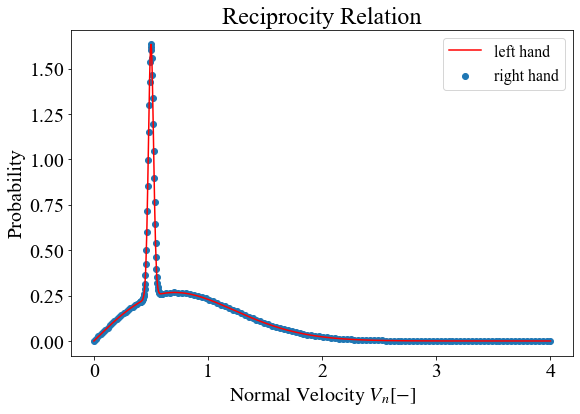

(0.38934017335491455, 0.38940039153570233)

In [4]:
def theoDataNormalNeg(x):
    def diracFunc(x):
        return 17.85*np.exp(-x**2/0.001)
#         return 5.641896*np.exp(-x**2/0.01)
    f1 = 2* (-VI)* np.exp(-np.power(VI, 2))
    return alpha*f1 + (1-alpha)*diracFunc(VI+x)


righthand_theo = X*np.exp(-X**2)*theoDataNormalNeg(X)
lefthand_theo = np.abs(VI)*np.exp(-VI**2)*theo_y
plt.figure(figsize=(9, 6))
plt.plot(X, lefthand_theo, label="left hand", c='r')
plt.scatter(X, righthand_theo, label="right hand")
plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
plt.ylabel("Probability")
plt.title("Reciprocity Relation")
plt.legend(fontsize=16)
# plt.savefig("./DEPA_Maxwellian_normal_detailed_balance_theo.png")
plt.show()

integrate.simps(righthand_theo, X), integrate.simps(lefthand_theo, X)

# Symbolic Regression

## Running Symbolic Regression
In this section, we run the symbolic regression with self-made function, thanksfully, the hyper-parameters this time could give us a good work, but for further work, I am going to establish a class or function which contain all the information together, so that we could train sepcific hyper-paramteter within a range of numer to gain the best regressor object. Of course, the constraint in the job shuld be further invextigated, which has not been done so much until now.

### Symbolic Regression Object
In this subsection, we run the code and print the mathematical symbolic expression, i.e., 
$$ f = 0.003 \times x \times \mathrm{exp}(-x^2)
\label{eq: symbolic normal expression}
$$
, where $x$ is the scaled normal velocity here, which is very close to the theoretical data when using $v_m$ to multiply $x$ here. 

\textbf{Notice}: 
- The constant range has been modified to 0.02, which makes sense here. 
- Parameter list
                                   population_size=1500, 
                                   function_set=fun_set,
                                   generations=300,
                                   stopping_criteria=0.00035,
                                   const_range=(-const_limit, const_limit),
                                   p_crossover=0.7,
                                   p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05,
                                   p_point_mutation=0.1,
                                   max_samples=0.9,
                                   verbose=1,
                                   parsimony_coefficient=0.01,
                                   random_state=0,
                                   n_jobs=2,
                                   low_memory=True

In [5]:
# self-made function
def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    _EPS = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_x2 = np.abs(x2, dtype=np.float64)
        return np.where(
            np.abs(x2) > _EPS, np.divide(x1, x2),
            np.sign(x2) * np.divide(x1, abs_x2 + _EPS))


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        exp_f = np.exp(x**2)
        return np.where(exp_f > 8.9e6, 0, exp_f)

In [7]:
class SelfSyblicRegression():
    """
    Create a class contains=ing all the function we need yo complement
    symbolic regression
    """
    def __init__(self, X, y, const_range, prob_data):
        self.xdata = X
        self.ydata = y
        self.const_range = const_range
        self.f_theo = prob_data['theo']

    def createFunSet(self):
        """
        This is the function to create function set.
        """
        expo_fun = make_function(function=_protectedExp, name='self_exp', arity=1)
        fun_set = ['add', 'sub', 'mul', 'div', expo_fun]

        return fun_set
    
    def symRegression(self):
        const_limit = self.const_range
        fun_set = self.createFunSet()

        # Symbolic Regression object
        est_gp = SymbolicRegressor(population_size=10000,
                                   function_set=fun_set,
                                   generations=1000,
                                   stopping_criteria=0.05,
                                   const_range=(-const_limit, const_limit),
                                   p_crossover=0.7,
                                   p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05,
                                   p_point_mutation=0.1,
                                   max_samples=0.9,
                                   verbose=1,
                                   metric="mse",
                                   parsimony_coefficient="auto",
                                   random_state=0,
                                   n_jobs=4,
                                   low_memory=True)
        
        return est_gp
        
    def printExpressionInfo(self, est_gp):
        """
        This is the function to give final information after symbolic regression,
        and the esymbolic mathematical repression will be printed out.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'self_exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set
        
        print(est_gp)
        # print('R2:', est_gp.score(X_test[:, np.newaxis], y_test))  # Give estimation score
        next_e = sympy.sympify(str(est_gp._program), locals=converter)
        print('Expression:', next_e)
        
        return next_e
        
    def plotGraph(self, est_gp):
        """
        This is the function to plot the subtree structured individual
        Variables:
            est_gp: symbolic regressior after fitting
        """
        graph = est_gp._program.export_graphviz()
        graph = pydotplus.graphviz.graph_from_dot_data(graph)
        img = Image(graph.create_png())
        display(img)
        
    def plotProb(self, next_e):
        """
        This is the function to plot the trend of probablity along the normal
        velocity.
        """
        symplot(next_e, xlim=[0, 3], adaptive=False, nb_of_points=400)
        
    def plotComparisonNormal(self, next_e, path):
        """
        Variables:
            next_e: Symbolic expression
            path: File path stored picture
        """
        X0 = sympy.symbols('X0')  # Create the symbols object
        x_scale_list = self.xdata
        est_value = [next_e.subs({X0:value}) for value in x_scale_list] 
        
        # Plot the graph 
        fig = plt.figure(figsize=(9, 6), dpi=600)
        plt.plot(x_scale_list, self.ydata, label='Traning set', linewidth=2, c='#0e72cc')
        plt.plot(x_scale_list, self.f_theo, label='Theoretical data', linewidth=3.5, c='#f59311')
        plt.plot(x_scale_list, est_value, label='Symboic data', linewidth=2, c='#d12a6a')
        plt.xlabel('$\mathrm{Normal\ velocity}\ V_n[-]$')
        plt.ylabel('Probability')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        
        # Find the maximum difference
        difference_array = self.f_theo*Vm - est_value*np.array(Vm) 
        index = np.argmax(difference_array)
        max_diff = difference_array[index] / (self.f_theo[index]*Vm) * 100 # It should be 100 percent
        plt.title('Velocity distribution of normal velocity \n Maximum difference: {:.2}%'.format(max_diff))
        plt.legend(fontsize=20)
        plt.savefig(path)
        
        plt.show()


    def run(self):
        """
        This is the main function that help us run the whole symbolic regression.
        """
        # 1. Create estimation object of gplearn
        est_gp = self.symRegression()
        
        # Change the data dimension, so that we could feed it into symbolic regression ovject.
        X_train_1 = self.xdata[:, np.newaxis]
        y_train_1 = self.ydata

        # 2. Fit the data
        est_gp.fit(X_train_1, y_train_1)

        # 3. Print expression
        print('-'*50, 'INFO', '-'*50)
        next_e = self.printExpressionInfo(est_gp) # symbolic expression
        
        # 4. Plot Graph
        print('-'*50, 'SUBTREE', '-'*50)
        self.plotGraph(est_gp)

        # 5. Plot probability 
        print('-'*50, 'PROBABILITY', '-'*50)
        self.plotProb(next_e)
        
        return next_e
        

(170,)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.71      7.61736e+44       22         0.533831          1.69019    110.23m
   1     4.94      1.89918e+23        6          0.54036         0.760845     73.74m
   2     2.16      4.04727e+26        1         0.795477          2.51012     66.64m
   3     1.51      2.94247e+30        5         0.757651         0.634052     66.39m
   4     1.49      4.44655e+23       24          0.60988          1.32559     62.75m
   5     1.49      1.03638e+19       24         0.628463         0.897325     62.02m
   6     1.52       1.9478e+22        1         0.735655          2.53258     60.84m
   7     1.50      1.44256e+24        6         0.622353          1.05428     61.80m
   8     1.49      3.03198e+17        3         0.703602          3.28017  

  94     1.48      5.83371e+21        1         0.644504          3.35293     58.95m
  95     1.45      3.24139e+34       14         0.540196          1.21485     60.86m
  96     1.54      4.74096e+22        1         0.579763          4.06935     57.87m
  97     1.49      1.72611e+29        1         0.583304          4.07424     58.93m
  98     1.51      1.70004e+22        6         0.532638          1.21723     58.60m
  99     1.46      4.15171e+23        6         0.635688         0.762562     58.96m
 100     1.52      7.29225e+24       19         0.542101          1.13922     58.42m
 101     1.49      1.37243e+22        1         0.685925           3.1139     58.37m
 102     1.53      2.05537e+22        1         0.669001           3.1499     60.82m
 103     1.51      2.98994e+23        1         0.661837          3.33068     58.05m
 104     1.50      2.94339e+29        1         0.649254          3.68529     58.90m
 105     1.43      1.24669e+30        6         0.586235         

 191     1.50      1.22262e+22        6         0.569689         0.935906     53.88m
 192     1.54      1.33846e+21       20         0.577533         0.820332     54.64m
 193     1.53      8.47768e+22       13         0.579676         0.597238     52.59m
 194     1.52      5.47119e+26       25         0.652739         0.708989     52.52m
 195     1.54      3.31229e+11        1         0.576892          3.97806     52.49m
 196     1.55      9.55659e+26        1         0.612807          3.72812     51.88m
 197     1.54      8.67477e+21        1         0.592823          3.95181     51.33m
 198     1.50      8.93411e+22        1         0.550495          4.33276     53.07m
 199     1.56       2.3606e+23        1         0.648849          3.44757     52.11m
 200     1.51      6.15506e+21        1         0.644439          3.76625     54.34m
 201     1.52       1.4777e+23        1         0.593141           3.8959     54.52m
 202     1.55      1.39158e+23        6          0.54051         

 288     1.55      3.89335e+23        1         0.643147          3.45506     48.41m
 289     1.55      8.56267e+21        1         0.618054           3.9683     47.14m
 290     1.51      2.07031e+21        1         0.646922          3.37842     48.15m
 291     1.52      4.75478e+20       58         0.476179          1.28371     44.74m
 292     1.58       4.2314e+22       23         0.579904         0.570659     46.52m
 293     1.52      3.46289e+28        1         0.613191          3.72466     46.84m
 294     1.53      2.74805e+19        6         0.613306              1.1     45.46m
 295     1.53      1.58855e+32        1         0.577957           4.0856     46.98m
 296     1.50      6.14474e+21        1         0.634971          3.51943     46.82m
 297     1.51      2.84215e+27        1         0.589713          3.92676     46.23m
 298     1.51      8.21305e+21        6         0.600256         0.952955     45.54m
 299     1.48      8.72172e+22        1         0.598256         

 385     1.47      1.22825e+22        1         0.659054          3.30268     41.03m
 386     1.48      3.19013e+34        6         0.591757         0.202892     38.72m
 387     1.58      1.10404e+25        1         0.624083          3.67047     40.13m
 388     1.56      5.88256e+35        1         0.594046          3.89697     39.59m
 389     1.51      5.49828e+22        1         0.516661          4.63727     40.05m
 390     1.55       1.5949e+23        1         0.617048          3.60004     40.35m
 391     1.52      1.30425e+22        1         0.661002          3.40047     39.35m
 392     1.51      4.34295e+21        1         0.652183          3.37374     40.22m
 393     1.57      3.71147e+20        6         0.566369          1.36701     40.59m
 394     1.51      6.35973e+21       14         0.635889          1.24789     38.66m
 395     1.49      6.14127e+21        1           0.6862          3.05012     39.25m
 396     1.53      1.34126e+28        1         0.647399         

 482     1.53      1.99199e+33        1         0.583533           3.9124     33.76m
 483     1.52      1.05845e+36        1         0.590338          3.84043     34.20m
 484     1.53      1.79956e+27        1         0.577464          4.33361     33.43m
 485     1.51      1.76557e+26        1         0.556416          4.27947     34.49m
 486     1.52      3.71659e+27        9         0.642385          1.33939     33.27m
 487     1.53      5.70595e+22        7         0.613988          1.50905     35.61m
 488     1.50      2.93023e+24        1          0.61197          3.77949     34.36m
 489     1.49      1.84239e+22        1         0.607855          3.81478     36.57m
 490     1.55      6.13434e+21        1         0.614746          3.70145     35.82m
 491     1.51       7.6627e+22        1         0.640581          3.52198     33.58m
 492     1.56      3.50418e+27       12         0.535252          1.75596     34.43m
 493     1.50      8.44714e+21        6         0.562025         

 579     1.53      2.68503e+22        1         0.571427          4.02135     26.87m
 580     1.53      1.22336e+28        1         0.591154          3.96683     27.94m
 581     1.57       8.1465e+22        1         0.579326          4.07328     27.70m
 582     1.57       2.4857e+28        1         0.615806          3.74497     27.81m
 583     1.47      1.40606e+41        6          0.55019          1.00933     27.43m
 584     1.52      2.81904e+24        1         0.616454          3.68608     26.25m
 585     1.53      8.35578e+24        1         0.596466          3.87518     26.57m
 586     1.53      8.72812e+21        1         0.626136            3.652     26.58m
 587     1.49      6.14184e+21        1          0.60219          3.73034     26.81m
 588     1.54      1.78488e+20        1         0.563982          4.16754     27.32m
 589     1.55      5.09023e+23        7          0.66509          1.50082     26.33m
 590     1.50      1.10154e+22        1         0.648519         

 676     1.46      6.30705e+19        1         0.630211          3.49229     20.60m
 677     1.51      4.48194e+28        1         0.642992          3.74385     20.65m
 678     1.55      1.25761e+22       85         0.582699          1.21682     20.53m
 679     1.48      7.76416e+34        1         0.592525          3.95449     22.34m
 680     1.54      1.46124e+32        1         0.614609          3.75574     21.88m
 681     1.51      5.70621e+18        6         0.578264         0.773553     20.97m
 682     1.51       5.1661e+19        1         0.604478          3.84692     20.93m
 683     1.51      1.91586e+22        1         0.572729          4.13266     20.72m
 684     1.56      6.33335e+21        1         0.621673          3.57585     20.18m
 685     1.51       3.8557e+25        1         0.612813           3.7719     20.22m
 686     1.49       1.8267e+22        1         0.606794          3.77302     20.21m
 687     1.50       2.3473e+17        1         0.626446         

 773     1.52      6.13893e+21       32         0.602784         0.787513     14.97m
 774     1.53      4.81906e+20        1         0.611601          3.78281     13.90m
 775     1.51      1.55095e+23        1          0.57715          4.09287     13.88m
 776     1.55      1.78476e+23        1         0.606819          3.82585     13.68m
 777     1.54       1.7268e+34        6         0.605912         0.116028     14.54m
 778     1.49      1.53604e+23        6         0.618251          1.25304     14.17m
 779     1.54      6.59989e+21        1         0.610217           3.6581     13.76m
 780     1.53      8.36604e+21        1         0.562767          4.15732     14.43m
 781     1.49      1.29147e+23        1          0.62012          3.70614     14.33m
 782     1.50      8.58376e+23        1         0.588574          3.99005     13.85m
 783     1.49      1.05515e+24        1         0.616275           3.6877     13.79m
 784     1.51      8.70702e+31        6         0.614649         

 870     1.55      3.72763e+26       23          0.64176         0.588387      8.17m
 871     1.56      1.83814e+23        1         0.695647          2.89316      8.10m
 872     1.49      2.08875e+14        1         0.655141          3.27463      8.08m
 873     1.45      3.63006e+19        1         0.590284          3.97466      8.28m
 874     1.53      1.41496e+24        1         0.602034           3.7526      8.00m
 875     1.56      6.14121e+21        1         0.615392          3.74869      8.11m
 876     1.51      1.51613e+22        6         0.500712          1.01188      7.71m
 877     1.48      1.82325e+26        1         0.617541          3.72934      8.12m
 878     1.51      6.84051e+21        1         0.545183          4.26426      7.98m
 879     1.53      2.12714e+22        1         0.547801          4.31317      7.81m
 880     1.51      2.73228e+34        1         0.634669           3.5752      7.52m
 881     1.51      2.86135e+23        1         0.595037         

 967     1.50      5.57612e+21        1         0.577363          3.96208      2.00m
 968     1.53      2.98217e+37        1         0.610871          3.78938      2.01m
 969     1.58      6.13852e+21        1         0.647324          3.34499      1.87m
 970     1.50      2.50547e+25        1          0.57388          3.99927      1.94m
 971     1.53      3.96909e+22       12         0.562788          1.66651      1.80m
 972     1.53      2.37609e+18        1         0.624459          3.53386      1.71m
 973     1.52      6.05387e+21        1         0.574016          4.00476      1.67m
 974     1.55      1.40261e+24        6         0.579046         0.887509      1.61m
 975     1.56      3.98944e+35        1          0.53846          4.30391      1.50m
 976     1.55      6.24715e+21        1         0.603465          3.73972      1.43m
 977     1.55      2.30377e+32        1         0.578002          3.96888      1.39m
 978     1.54      6.07744e+22        6         0.594019         

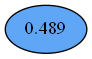

-------------------------------------------------- PROBABILITY --------------------------------------------------


D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\ma\core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,


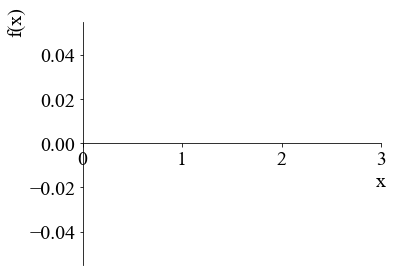

In [8]:
vi_list_normal = np.array([VI for i in range(len(X.squeeze()))])
X_NORMAL = np.vstack((X.squeeze(), vi_list_normal)).T # 530 * 2 

prob_data = {'theo':theo_y}
symbolic_object = SelfSyblicRegression(X, theo_y, const_range=5, prob_data=prob_data, )
next_e = symbolic_object.run()

In [16]:
X_NORMAL.shape, theo_y.shape

((170, 2), (170,))

In [23]:
normal_path = './gp_normal.png'
symbolic_object.plotComparisonNormal(next_e, path=normal_path)

NameError: name 'Vm' is not defined

<Figure size 5400x3600 with 0 Axes>

In [17]:
x = sympy.symbols('X0')
sympy.init_printing(use_unicode=True)

next_e_new = next_e.subs(x, x/Vm)
# Set the integration limit
# lower_limit = sympy.N(xdata_normal.min()/Vm, 4)
# upper_limit = sympy.N(xdata_normal.max()/Vm, 4)
lower_limit = 0
upper_limit = sympy.oo
int1 = sympy.Integral(next_e_new, (x, lower_limit, upper_limit))
display(Latex(f"$${sympy.latex(int1)} = {sympy.latex(int1.doit())} = {sympy.latex(int1.doit().evalf(6))}$$"))

<IPython.core.display.Latex object>

## Comparison between Symbolic Regression and Empirical Data
In this section, we plot four kinds of data in one graph, i.e., empirical data, symbolic regression data, fitted data, and theoretical data. From the graph, it is clearly noticed that the symbolic line is extremely closed to the theoretical line, both of which could reflect the empirical data well. 

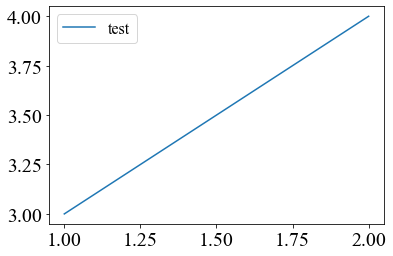

In [18]:
plt.plot(np.array([1, 2]), np.array([3, 4]), label='test')
plt.legend(fontsize=16)

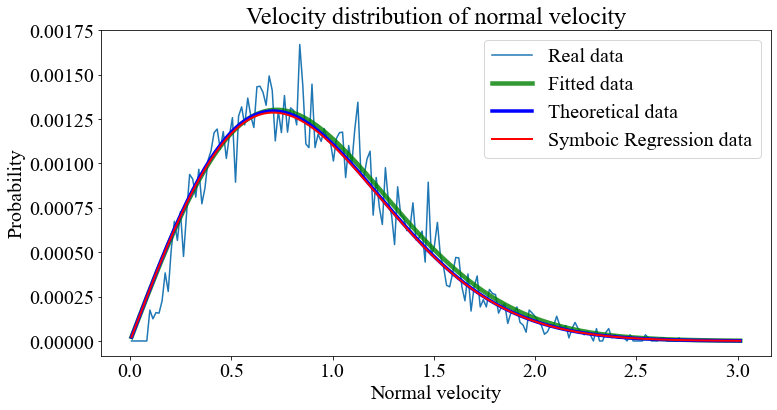

In [19]:
X0 = sympy.symbols('X0')  # Create the symbols object
x_scale_list = xdata_normal/Vm
est_value = [next_e.subs({X0:value}) for value in x_scale_list] 

# Plot the graph 
fig = plt.figure(figsize=(12, 6))
plt.plot(xdata_normal / Vm, ydata_normal, label='Real data')
plt.plot(xdata_normal / Vm, fit_y_normal, label='Fitted data', linewidth=4.5, c='g', alpha=0.8)
plt.plot(xdata_normal / Vm, f_normal, label='Theoretical data', linewidth=3.5, c='b')
plt.plot(x_scale_list, est_value, label='Symboic Regression data', linewidth=2, c='r')
plt.xlabel('Normal velocity', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of normal velocity',
          fontdict=title_format)
plt.legend()

plt.savefig('./figure/diffuse_model_vn and symbolic regression data_2.png')

## Comparison to Conventional Machine Learning
Even we could gain a really good result on training dataset, we did a little terrible in our testing set compared to the decession tree and random forest tree methods. For this part, I am not going to spend much time on it due to the non-importance for our project.

In [20]:
# Create conventional regression object
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train_1, y_train_1)
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train_1, y_train_1)

b = np.argsort(X_test)
X_test_new = np.array([X_test[i] for i in b])
y_test_new = np.array([y_test[i] for i in b])

X_test_1 = X_test_new[:, np.newaxis]  # Change the dimension

# Predict the data and gain the score
y_gp = est_gp.predict(X_test_1)
score_gp = est_gp.score(X_test_1, y_test)
y_tree = est_tree.predict(X_test_1)
score_tree = est_tree.score(X_test_1, y_test)
y_rf = est_rf.predict(X_test_1) 
score_rf = est_rf.score(X_test_1, y_test)

NameError: name 'X_train_1' is not defined

In [ ]:
fig = plt.figure(figsize=(16, 6))
font_format_title = {'family': 'Times New Roman', 'size': 20}
font_format = {'family': 'Times New Roman', 'size': 16}

info_list = [(y_gp, score_gp, "Symbolic Regressor"),
             (y_tree, score_tree, "Decession Tree"),
             (y_rf, score_rf, 'Random Forest')]

for i, (y, score, title) in enumerate(info_list):
    ax = fig.add_subplot(1, 3, i + 1)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax.set_xlabel('Velocity', fontdict=font_format)
    ax.set_ylabel('Probability', fontdict=font_format)
    ax.plot(X_test_new/Vm, y, label='Code')
    ax.plot(X_test_new/Vm, y_test_new, label='Orignal')
    ax.text(-3, 0.0009, r"$R^2=\/ %.6f$" % score, fontsize=14)
    plt.title(title, fontdict=font_format_title)
    plt.legend()
plt.show()